# Perform a large-scale principal component analysis faster using Amazon SageMaker

Elena Ehrlich, Hanif Mahboobi

Principal Component Analysis (PCA) is an unsupervised learning algorithm that attempts to reduce the dimensionality (e.g., number of features) within a dataset while still retaining as much information as possible.  This notebook demonstrates the scalability of the Amazon SageMaker PCA on a large real-world data set.

#### Download and load the NIPS data set. 

This data set is the distribution of words in the full texts of NIPS conference papers that were published from 1987 to 2015, in the form of an 11,463-by-5,812 matrix of word counts [Perrone et al., 2016]. Each column represents a corresponding NIPS paper and contains the number of times each of the 11,463 words appeared in that paper. The names of the columns identify the corresponding NIPS document by the format PublicationYear_PaperID, for a total of 5,812 documents. This data set is publicly available at https://archive.ics.uci.edu/ml/datasets/NIPS+Conference+Papers+1987-2015#.

In [4]:
import sys
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00371/NIPS_1987-2015.csv
filename = 'NIPS_1987-2015.csv'

import pandas as pd
data = pd.read_csv('NIPS_1987-2015.csv', index_col=0)      
data

--2018-09-14 22:15:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00371/NIPS_1987-2015.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133587258 (127M) [text/csv]
Saving to: ‘NIPS_1987-2015.csv.1’

NIPS_1987-2015.csv. 100%[===================>] 127.40M  38.2MB/s    in 4.9s    

2018-09-14 22:15:21 (26.1 MB/s) - ‘NIPS_1987-2015.csv.1’ saved [133587258/133587258]



,1987_1,1987_2,1987_3,1987_4,1987_5,1987_6,1987_7,1987_8,1987_9,1987_10,...,2015_394,2015_395,2015_396,2015_397,2015_398,2015_399,2015_400,2015_401,2015_402,2015_403
abalone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbeel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbott,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbreviate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbreviated,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abeles,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
abernethy,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,12,0,0,0,1,0
abilistic,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abilities,0,1,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Convert the transposed, standardized data to binary stream

#### Specify S3 file paths for training data and for output location. Upload data to S3.        

Specify the S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.


In [5]:
matrx = data.transpose().apply(lambda x: (x-x.mean())/x.std()).as_matrix()

import io
import sagemaker.amazon.common as smac
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, matrx)
buf.seek(0)

<class 'numpy.ndarray'>
11463
(5811, 11463)


0

In [6]:
import boto3
bucket = 'nmahesh1-sagemaker'
prefix = 'sagemaker/pca-nips'
key = 'NIPS-bytes-data'

import os
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))


Uploaded training data location: s3://nmahesh1-sagemaker/sagemaker/pca-nips/train/NIPS-bytes-data
Training artifacts will be uploaded to: s3://nmahesh1-sagemaker/sagemaker/pca-nips/output


#### Instantiate Amazon SageMaker PCA

- We configure the container image to be used for the region in which we are running.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the get_execution_role function to obtain the role arn which was specified when creating the notebook.
- We can now define the estimator that will launch the training job.


In [7]:
# Lookup container address per AWS region.                                                   
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/pca:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/pca:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/pca:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/pca:latest'}

# Get Amazon SageMaker IAM execution role.                                                          
from sagemaker import get_execution_role
role = get_execution_role()

# Create Amazon SageMaker session.                                                                  
import sagemaker
sess = sagemaker.Session()

# Instantiate Amazon SageMaker PCA with six arguments.                                              
pca = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.c5.18xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)


#### Specify PCA hyper-parameters 

We still want to specify the hyper-parameters for the PCA algorithm. The hyper-parameters are:  the number of features, the desired number of principal components to return, a Boolean to subtract each column's mean prior to matrix decomposition, whether to perform `regular` or `randomized` PCA, and lastly, the mini-batch size. Refer to the documentation for a full description of the available parameters.

In [8]:
import numpy as np
pca.set_hyperparameters(feature_dim=np.shape(matrx)[1],
                        num_components=np.shape(matrx)[1]-1,
                        #num_components=2,
                        subtract_mean=True,
                        algorithm_mode='regular',
                        mini_batch_size=5812)


#### Kick-off PCA fitting.  

In [9]:
import time 
pca.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: pca-2018-09-14-22-16-36-617


....................
Docker entrypoint called with argument(s): train
[09/14/2018 22:19:50 INFO 140051053938496] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[09/14/2018 22:19:50 INFO 140051053938496] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'algorithm_mode': u'regular', u'feature_dim': u'11463', u'mini_batch_size': u'5812', u'num_components': u'11462', u'subtract_mean': u'True'}
[09/14/2018 22:19:50 INFO 140051053938496] Final configuration: {u'num_components': u'11462', u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'True', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'feature_dim': u'11463', u'extra_compone

#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 73746.97303771973, "sum": 73746.97303771973, "min": 73746.97303771973}}, "EndTime": 1536963668.504641, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1536963594.757118}

[09/14/2018 22:21:08 INFO 140051053938496] Test data is not provided.
#metrics {"Metrics": {"totaltime": {"count": 1, "max": 78050.99892616272, "sum": 78050.99892616272, "min": 78050.99892616272}, "setuptime": {"count": 1, "max": 42.85097122192383, "sum": 42.85097122192383, "min": 42.85097122192383}}, "EndTime": 1536963668.825298, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1536963668.504703}


Billable seconds: 229


#### Download and unpack returned PCA model artifact to extract the fitted principal components and eigenvalues 

Let’s download the tarred output, the contents of which can be read as an MXNet ndarray. The ndarray has three attributes: 
- **mean**, an array of column means
- **s**, an ndarray of singular values
- **v**, an ndarray of principal component vectors.

In [18]:
pca_predictor = pca.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')
from sagemaker.predictor import csv_serializer, json_deserializer

pca_predictor.content_type = 'text/csv'
pca_predictor.serializer = csv_serializer
pca_predictor.deserializer = json_deserializer
#job_name = pca.latest_training_job.name

os.system('aws s3 cp {}/{}/output/model.tar.gz ./'.format(output_location, job_name))
!tar xzvf model.tar.gz

import mxnet as mx
pca_model = mx.ndarray.load('model_algo-1')

a = np.zeros((np.shape(matrx)[0],np.shape(matrx)[1]-1 ))
for i in range(4):
    result = pca_predictor.predict(matrx[i])
    for j in range(np.shape(matrx)[1]-1):
        a[i][j] = result['projections'][0]['projection'][np.shape(matrx)[1]-2-j]
np.save('trasnformedData_transposed_Sagemaker.npy',a)
print(a[0][0:10])
print(a[1][0:10])
print(a[2][0:10])


model_algo-1
[-5.50669622  8.21927452 -2.97324967 -4.13959694 -0.78117079 -2.38653541
 -0.77417517  1.29966486  1.9158082  -0.43050188]
[-12.10831261   0.21831392   2.68579221  -5.75496674   4.49205685
  10.51807213  -2.78796482   9.99664211  -2.38656735  -2.01155519]
[-5.41326141  7.35251951 -3.31879091 -3.80100203 -0.33383927  0.59382427
 -1.10836923  2.85601854 -0.27757835  1.97182751]


#### Visualization of PCA output

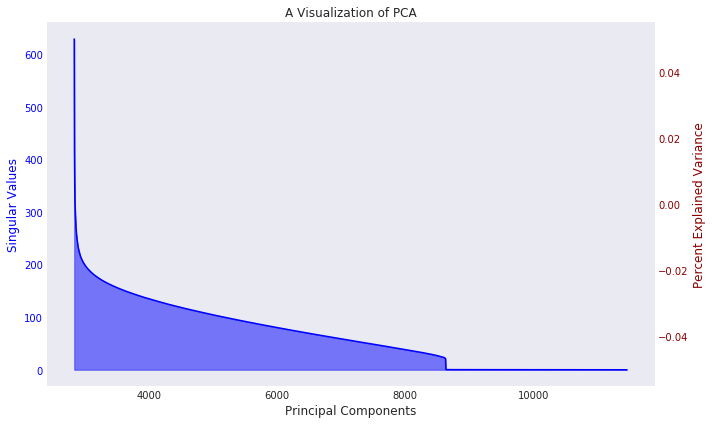

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')

fig = plt.figure(figsize=[10,6])
ax1 = fig.subplots()
t = range(len(singular_values))
ax1.plot(t, singular_values, 'b')
ax1.fill_between(t, 0, singular_values, color='b', alpha=0.5, label=None)
ax1.set_xlabel('Principal Components', fontsize=12)
ax1.set_ylabel('Singular Values', color='b', fontsize=12)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
explained_var = np.power(singular_values, 2.).cumsum() / np.power(singular_values, 2.).sum()
ax2.plot(t, explained_var, 'darkred')
ax2.set_ylabel('Percent Explained Variance', color='darkred', fontsize=12)
ax2.tick_params('y', colors='darkred')
plt.xticks(rotation=45)
plt.title('A Visualization of PCA')

fig.tight_layout()
plt.show()